# Introduction to Data Science – Homework 5
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

Due: Friday, February 23, 2024, 11:59pm.

In this homework you will use linear regression to study house prices in Salt Lake City.

## Your Data
Fill out the following information: 

*First Name: Logan*   
*Last Name: Correa*   
*E-mail: logan.correa@utah.edu*
*UID: u1094034*  


## Regression of real estate data
For this problem, you will analyze SLC real estate data. The dataset contains multiple listing service (MLS) real estate transactions for houses sold in 2015-16 in zip code 84103 ([SLC avenues neighborhood](https://www.google.com/maps/place/Salt+Lake+City,+UT+84103/@40.8030372,-111.8957957,12z/data=!3m1!4b1!4m5!3m4!1s0x87525f672006dded:0x311e638d9a1a2de5!8m2!3d40.810506!4d-111.8449346)). We are primarily interested in regressing the `SoldPrice` on the house attributes (`property size`, `house size`, `number of bedrooms`, etc...). 


### Task 1: Import the data 
Use the [`pandas.read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function to import the dataset. The data is contained in two files located in the same directory as this notebook: [`train1.csv`](train1.csv) and [`train2.csv`](train2.csv). After you import these files separately, concatenate them into one big dataframe. This pandas dataframe will be used for data exploration and linear regression. 

In [2]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm

#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [3]:
train1 = pd.read_csv('train1.csv')
train2 = pd.read_csv('train2.csv')

house = pd.concat([train1, train2])

### Task 2: Clean the data 

1. There are 206 different variables associated with each of the 348 houses in this dataset. Skim them and try to get a rough understanding of what information this dataset contains. If you've never seen a real estate listing before, you might take a look at one on [this](http://www.utahrealestate.com/) website to get a better sense of the meanings of the column headers in the dataset.  

+ Only keep houses with List Price between 300,000 and 900,000 dollars both inclusive. This is an arbitrary choice and we realize that some people are high rollers, but for our purposes we'll consider the others as outliers. 

+ Remove columns that you don't think contribute to the value of the house. This is a personal decision – what attributes of a house are important to you? 
You should at least keep the following variables since questions below will use them: `` ['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'DaysOnMkt', 'LstPrice', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']

+ Check the datatypes and convert any numbers that were read as strings to numerical values. (Hint: You can use [`str.replace()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.replace.html) to work with strings.) If there are any categorical values you're interested in, then you should convert them to numerical values as in Lecture. In particular, convert 'TotSqf' to an integer and add a column titled `Prop_Type_num` that is 
$$
\text{Prop_Type_num}_i = \begin{cases} 
2 & \text{if $i$-th listing is a townhouse} \\
1 & \text{if $i$-th listing is a condo} \\
0 & \text{if $i$-th listing is a single family house}
\end{cases}. 
$$
+ Remove the listings with erroneous `Longitude` (one has Longitude = 0) and `Taxes` values (two have unreasonably large values).

In [4]:
# Filter List Price and desired columns
house_clean = house[(house['LstPrice'] > 300000) & (house['LstPrice'] < 900000)]
house_clean = house_clean[['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'DaysOnMkt', 'LstPrice', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']]

# Check data types and convert to numeric
house_clean.dtypes
house_clean['TotSqf'] = pd.to_numeric(house_clean['Acres'], errors='coerce')

# Add Prop_Type_num column
house_clean['Prop_Type_num'] = house_clean['PropType'].map({'Single Family': 0, 'Townhouse': 2, 'Condo': 1})
house_clean.head()

,Acres,Deck,GaragCap,Latitude,Longitude,DaysOnMkt,LstPrice,PkgSpacs,PropType,SoldPrice,Taxes,TotBed,TotBth,TotSqf,YearBlt,Prop_Type_num
0,0.29,1,3,40.779524,-111.893542,7.0,725000,0,Single Family,752000,7244,4.0,5.0,0.29,1998,0
2,0.11,0,0,40.773972,-111.867470,4.0,390000,0,Single Family,390000,1816,3.0,1.0,0.11,1940,0
3,0.14,0,1,40.783009,-111.872100,12.0,445000,3,Single Family,443000,3260,3.0,2.0,0.14,1940,0
5,0.01,0,2,40.771693,-111.886951,12.0,339000,2,Condo,334000,2141,3.0,2.0,0.01,1976,1
6,0.14,1,2,40.783889,-111.872194,NaN,600000,2,Single Family,570000,4197,3.0,3.0,0.14,1950,0


### Task 3: Exploratory data analysis 

1. Explore the dataset. Write a short description of the dataset describing the number of items, the number of variables and check to see if the values are reasonable. 

+ Make a bar chart showing the breakdown of the different types of houses (single family, townhouse, condo). 

+ Compute the correlation matrix and use a heat map to visualize the correlation coefficients. 
    - Use a diverging color scale from -1 to +1 (see `vmin` and `vmax` parameters for [pcolor](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.pcolor.html))
    - Show a legend
    - Make sure the proper labels are visible and readable (see [`xticks`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.xticks.html) and the corresponding [`yticks`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.yticks.html).

+ Make a scatter plot matrix to visualize the correlations. Color-code the dots by property type. For the plot, only use a subset of the columns: `['Acres', 'LstPrice', 'PkgSpacs', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt' ]`. Determine which columns have strong correlations. 

+ Describing your findings. 


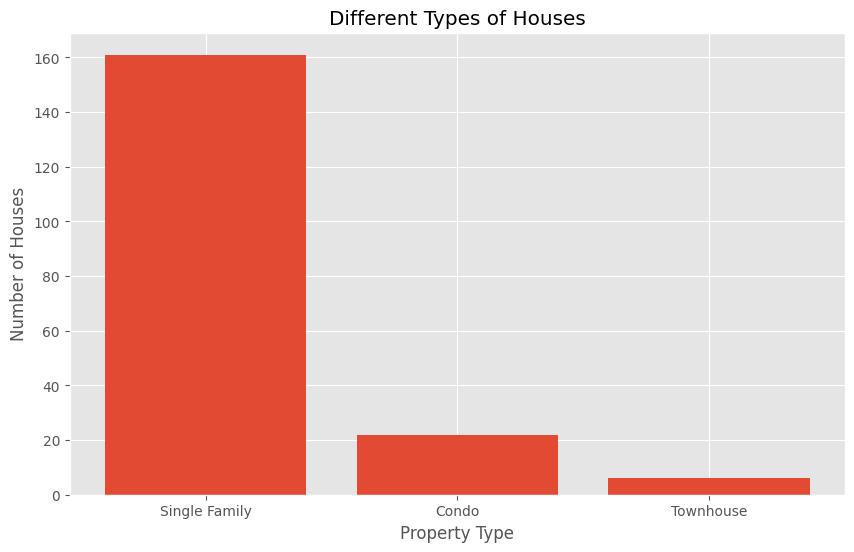

In [18]:
# explore dataset
house_clean.describe()

# Property type bar chart
plt.bar(house_clean['PropType'].unique(), house_clean['PropType'].value_counts())
plt.title('Different Types of Houses')
plt.xlabel('Property Type')
plt.ylabel('Number of Houses')
plt.show()

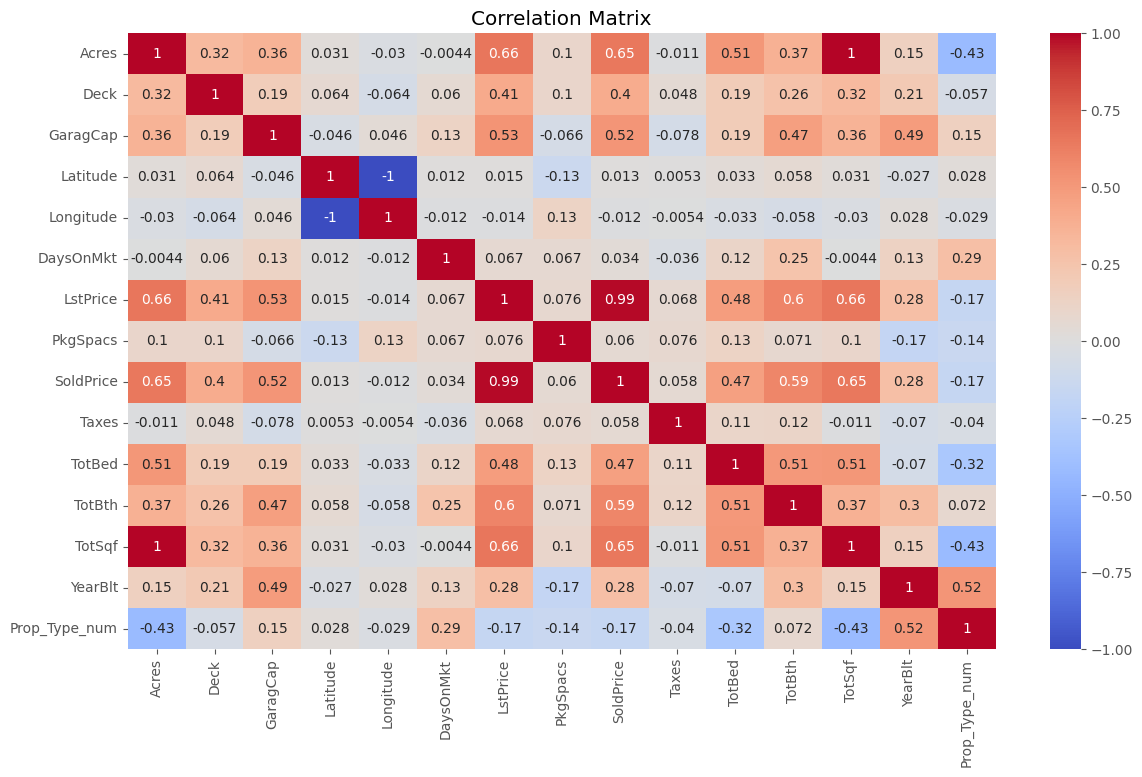

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove non-numeric columns and compute correlation matrix
house_numeric = house_clean.drop(columns=['PropType'])
correlation_matrix = house_numeric.corr()

# Plot correlation matrix
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


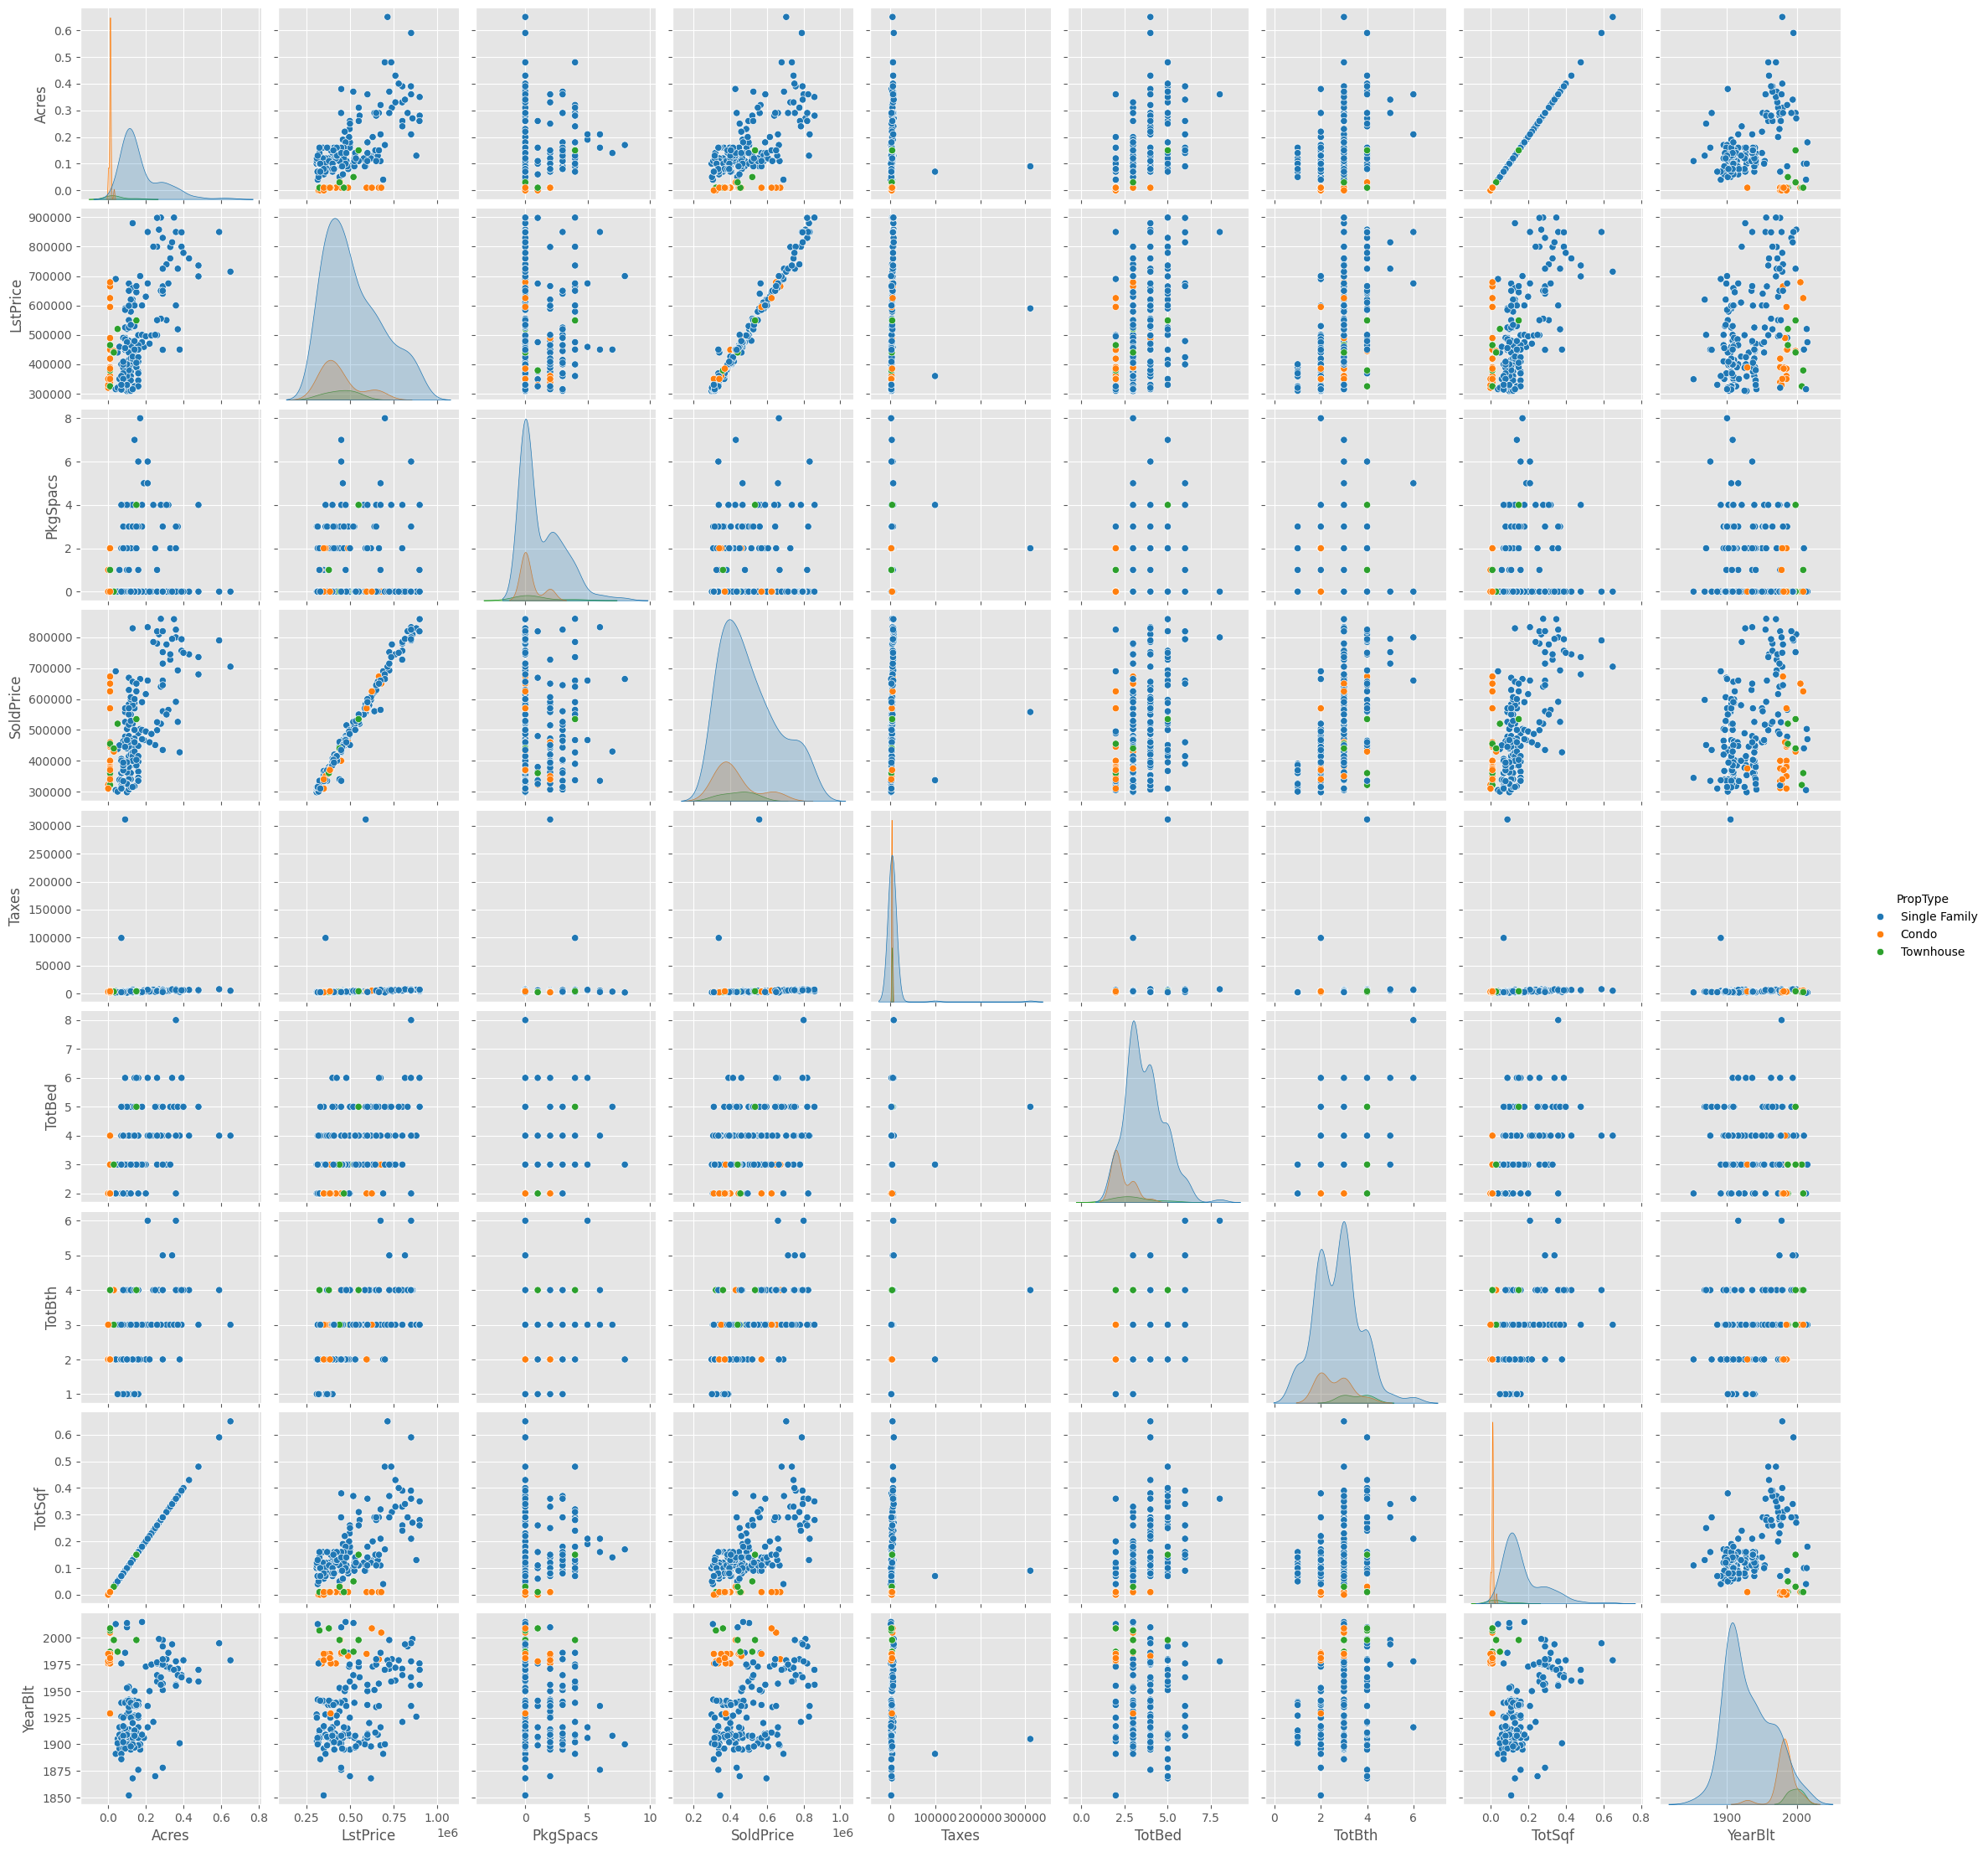

In [74]:
house_matrix = house_clean[['Acres', 'LstPrice', 'PkgSpacs', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt', 'PropType']]

# Use seaborn to plot the scatter plot matrix
sns.pairplot(house_matrix, hue = 'PropType', palette='tab10')
plt.title('Scatter Plot Matrix')
plt.show()




**Your Interpretation:** TODO

### Task 4: Geospatial plot
Two of the variables are the latitude and longitude of each listing. Salt Lake City is on this nice east-west, north south grid, so even a simple plot of lat and long makes sense. Create a scatterplot of these two variables. Use color to indicate the price of the house. How does the price depend on the house location?

What can you say about the relation between the location and the house price?  

In [6]:
# your code goes here


**Your Interpretation:** TODO

### Task 5: Simple  Linear Regression 
Use the `ols` function from the [statsmodels](http://www.statsmodels.org/stable/index.html) package to regress the Sold price on some of the other variables. Your model should be of the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x, 
$$
where $x$ is one of the other variables. 

You'll find that the best predictor of sold price is the list price. Report the R-squared value for this model (`SoldPrice ~ LstPrice`) and give an interpretation for its meaning. Also give an interpretation of $\beta_1$ for this model. Make a scatterplot of list price vs. sold price and overlay the prediction coming from your regression model. 

In [7]:
# Your code here


**Your Interpretation:** TODO

### Task 6: Multilinear Regression 
Develop a multilinear regression model for house prices in this neighborhood. We could use this to come up with a list price for houses coming on the market, so do not include the list price in your model and, for now, ignore the categorical variable Prop_Type. Your model should be of the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots +  \beta_n x_n, 
$$
where $x_i$ are predictive variables.


**Question 1**: If we wanted to start a 'house flipping' company, we'd have to be able to do a better job of predicting the sold price than the list price does. How does your model compare? 

Next look at the difference between list price and sold price explicitly. Calculate two new columns for your dataset. `DiffPriceAbsolute` and `DiffPriceRelative`.

* `DiffPriceAbsolute` - This is difference between sold price and list price. If it is positive, that means the house sold for more than it was listed at.
* `DiffPriceRelative` - This is the relative difference between sold price and list price. A value of 1.1 here means that the house sold for 110% of the asking price, and 0.9 means the house sold for 90% of the asking price.

Now, create two new models. One to predict `DiffPriceAbsolute`, and one to predict `DiffPriceRelative`. Use the same predictive variables as in the last model.


**Question 2**: Which of these two new models makes better predictions.

**Question 3**: Based on your answer to question two, why are these models different/the same.

To help justify your answer to question 3, train two models to predict `DiffPriceAbsolute` and `DiffPriceRelative` based on just `SoldPrice`. In addition, for each model make a scatterplots similar to Task 5 for these models.

In [8]:
# your code goes here


**Your Interpretation:** TODO - answer Questions 1, 2, and 3

### Task 7: Incorporating a categorical variable

Above, we considered houses, townhouses, and condos together, but here we'll distinguish between them. Consider the two regression models: 
$$
\text{SoldPrice} = \beta_0 + \beta_1 \text{Prop_Type_num}
$$
and 
$$
\text{SoldPrice} = \beta_0  + \beta_1 \text{Prop_Type_num} + \beta_2 \text{TotSqf}
$$
From the first model, it would appear that Property type is significant in predicting the sold price. On the other hand, the second model indicates that when you take into account total square footage, property type is no longer predictive. Explain this. (Hint: there is a confounder lurking here.) Make a scatterplot of TotSqf vs. SoldPrice where the house types are colored differently to illustrate your explanation. 

In [9]:
# Your code goes here


**Your Interpretation:** TODO